In [1]:
! pip3 list -v | grep torch 

torch                         2.3.1                                                          /home/samuel/.local/lib/python3.11/site-packages pip
torchaudio                    2.3.1                                                          /home/samuel/.local/lib/python3.11/site-packages pip
torchvision                   0.18.1                                                         /home/samuel/.local/lib/python3.11/site-packages pip


In [2]:
! pip list | grep tensorflow

tensorflow                    2.14.1
tensorflow-addons             0.23.0
tensorflow-datasets           4.9.6
tensorflow-estimator          2.14.0
tensorflow-examples           0.1703207612.1461250479831370929614362828255168868146460245314
tensorflow-hub                0.16.1
tensorflow-io-gcs-filesystem  0.34.0
tensorflow-metadata           1.15.0
tensorflow-model-optimization 0.8.0
tensorflow-probability        0.24.0
tensorflow-text               2.14.0


In [3]:
'''
When running this notebook, put this notebook and the zip file to the YOLO dataset in the same folder
'''
import os
import tensorflow as tf
import subprocess
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import ultralytics
ultralytics.checks()

import csv
import keras as keras
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import sklearn
import ultralytics
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import zipfile as zf

# !pip uninstall opencv-python opencv-python-headless -y
# !pip install opencv-python-headless
import cv2



Ultralytics YOLOv8.2.51 🚀 Python-3.11.0rc1 torch-2.3.1+cu121 CPU (Intel Core(TM) i7-9700 3.00GHz)
Setup complete ✅ (8 CPUs, 31.2 GB RAM, 354.0/456.9 GB disk)


In [4]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152 CODE TO MAKE IT USE CPU INSTEAD of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3*1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2024-08-15 09:35:47.284785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-15 09:35:47.284819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: d25ae9434b1d
2024-08-15 09:35:47.284828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: d25ae9434b1d
2024-08-15 09:35:47.284887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 555.42.2
2024-08-15 09:35:47.284913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  555.42.02  Release Build  (dvs-builder@U16-I3-A03-02-4)  Mon May 13 17:10:33 UTC 2024
GCC version:  gcc version 11.4.0 (Ubuntu 11.4

In [5]:
# !pip install ultralytics

In [8]:
columns_name = ['image_id', 'width', 'height', 'bbox']

def calc_percentage(df_total, df_part,file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100

# this is where you can load your custom dataset -> should be a zip in yolov8 format
#assume that leaf_detection.zip is in the same folder as the notebook 
def unzip_dataset(name, output_dir):
    files = zf.ZipFile(name, 'r')
    files.extractall(output_dir)
    files.close()
unzip_dataset('Leaf_detection.zip', 'Leaf_Detection')

leaf_detection_dir = 'Leaf_Detection'
train_csv = os.path.join(leaf_detection_dir, 'train.csv')
train_dir = os.path.join(leaf_detection_dir, 'train')
val_dir = os.path.join(leaf_detection_dir, 'val')

test_dir = os.path.join(leaf_detection_dir, 'test')

train_images = train_dir
test_images = test_dir
val_images = val_dir

nRowsRead = None # specify 'None' if want to read whole file

df = pd.read_csv(train_csv, delimiter=',', nrows = nRowsRead)
df.dataframeName = 'train.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

print(df)

random_seed = 42
random.seed(random_seed)

# Split the DataFrame into training(80%) and validation with test(20%) based on the unique file names
unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=random_seed)
train_df = df[df['image_id'].isin(train_filenames)]

# 10% for validation and 10% for test
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=0.5, random_state=random_seed)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]

train_percentage = calc_percentage(df,train_df,'image_id')
print(f'Elements in train_df({train_percentage}%):',len(train_df['image_id'].unique()))
train_df.head()


val_percentage = calc_percentage(df,val_df,'image_id')
print(f'Elements in val_df({val_percentage}%):',len(val_df['image_id'].unique()))
val_df.head()

test_percentage = calc_percentage(df,test_df,'image_id')
print(f'Elements in test_df({test_percentage}%):',len(test_df['image_id'].unique()))
test_df.head()

There are 5346 rows and 4 columns
           image_id  width  height                  bbox
0     LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1     LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2     LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3     LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4     LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]
...             ...    ...     ...                   ...
5341  LEAF_1112.jpg    416     416   [152, 43, 139, 345]
5342  LEAF_1112.jpg    416     416    [320, 80, 79, 261]
5343  LEAF_1113.jpg    416     416   [116, 34, 180, 313]
5344  LEAF_1114.jpg    416     416   [158, 11, 117, 397]
5345  LEAF_1115.jpg    416     416    [96, 84, 295, 225]

[5346 rows x 4 columns]
Elements in train_df(80.0%): 904
Elements in val_df(10.0%): 113
Elements in test_df(10.0%): 113


,image_id,width,height,bbox
307,LEAF_0019.jpg,1024,1024,"[722, 298, 302, 209]"
308,LEAF_0019.jpg,1024,1024,"[747, 459, 277, 166]"
309,LEAF_0019.jpg,1024,1024,"[870, 700, 154, 324]"
310,LEAF_0019.jpg,1024,1024,"[696, 655, 171, 200]"
311,LEAF_0019.jpg,1024,1024,"[421, 810, 222, 214]"


In [9]:

def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                 yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)

def create_yaml_data(yaml_file_name,output_dir,data):        
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, f'{yaml_file_name}.yaml')
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')
    return output_path

output_dir = 'Leaf_Detect_output' #or the path you want to use for the output dir 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if os.path.exists(output_dir):
    folders = [f.name for f in os.scandir(output_dir) if f.is_dir()]
    print("Folders:", folders)
else:
    print(f"The directory '{output_dir}' does not exist.")

yaml_file_name = 'data'
yaml_data = {
    'train': '../train/images',
    'val': '../valid/images',
    'test': '../test/images',
    'format':'line_break',
    'nc': 1,
    'names': ['leaf']
}

#this makes the yaml file and stores the path in data_yaml
data_yaml = create_yaml_data(yaml_file_name,output_dir,yaml_data)

Folders: []
YAML file created successfully in Leaf_Detect_output/data.yaml.


In [10]:
def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)    
    unique_image_ids = df['image_id'].unique()    
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)  
        if not os.path.exists(target_path):
            if os.path.exists(source_path):
                shutil.copy(source_path, target_path)
            else:
                print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')

def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)    
    data = {}    
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)        
        if image_id not in data:
            data[image_id] = []        
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")    
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')

print(os.getcwd())
      
# Data for train
txt_files_train = f'{output_dir}/train/labels'
img_files_train = f'{output_dir}/train/images'

all_images_dir = train_dir
move_images_to_directory(train_df, all_images_dir, img_files_train)
dataframe_yolofiles(train_df, txt_files_train)

# Data for validation
txt_files_val = f'{output_dir}/valid/labels'
img_files_val = f'{output_dir}/valid/images'
move_images_to_directory(val_df, all_images_dir, img_files_val)
dataframe_yolofiles(val_df, txt_files_val)

# Data for test
txt_files_test = f'{output_dir}/test/labels'
img_files_test = f'{output_dir}/test/images'
move_images_to_directory(test_df, all_images_dir, img_files_test)
dataframe_yolofiles(test_df, txt_files_test)

/tf/Samuel_Plant_Disease/Yolo_test_run2
Total images moved to: Leaf_Detect_output/train/images
Total text files created in: Leaf_Detect_output/train/labels
Total images moved to: Leaf_Detect_output/valid/images
Total text files created in: Leaf_Detect_output/valid/labels
Total images moved to: Leaf_Detect_output/test/images
Total text files created in: Leaf_Detect_output/test/labels


/tf/Samuel_Plant_Disease/Yolo_test_run2
LEAF_0009.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0009.txt
LEAF_0010.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0010.txt
LEAF_0011.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0011.txt
LEAF_0013.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0013.txt
LEAF_0014.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0014.txt
LEAF_0015.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0015.txt
LEAF_0016.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0016.txt
LEAF_0017.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0017.txt
LEAF_0018.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0018.txt
LEAF_0020.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0020.txt
LEAF_0022.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0022.txt
LEAF_0023.jpg
(1024, 1024, 3)
Leaf_Detect_output/train/labels/LEAF_0023.txt
LEAF_0024.jpg
(1024, 1024, 3)
Leaf_Detect_output

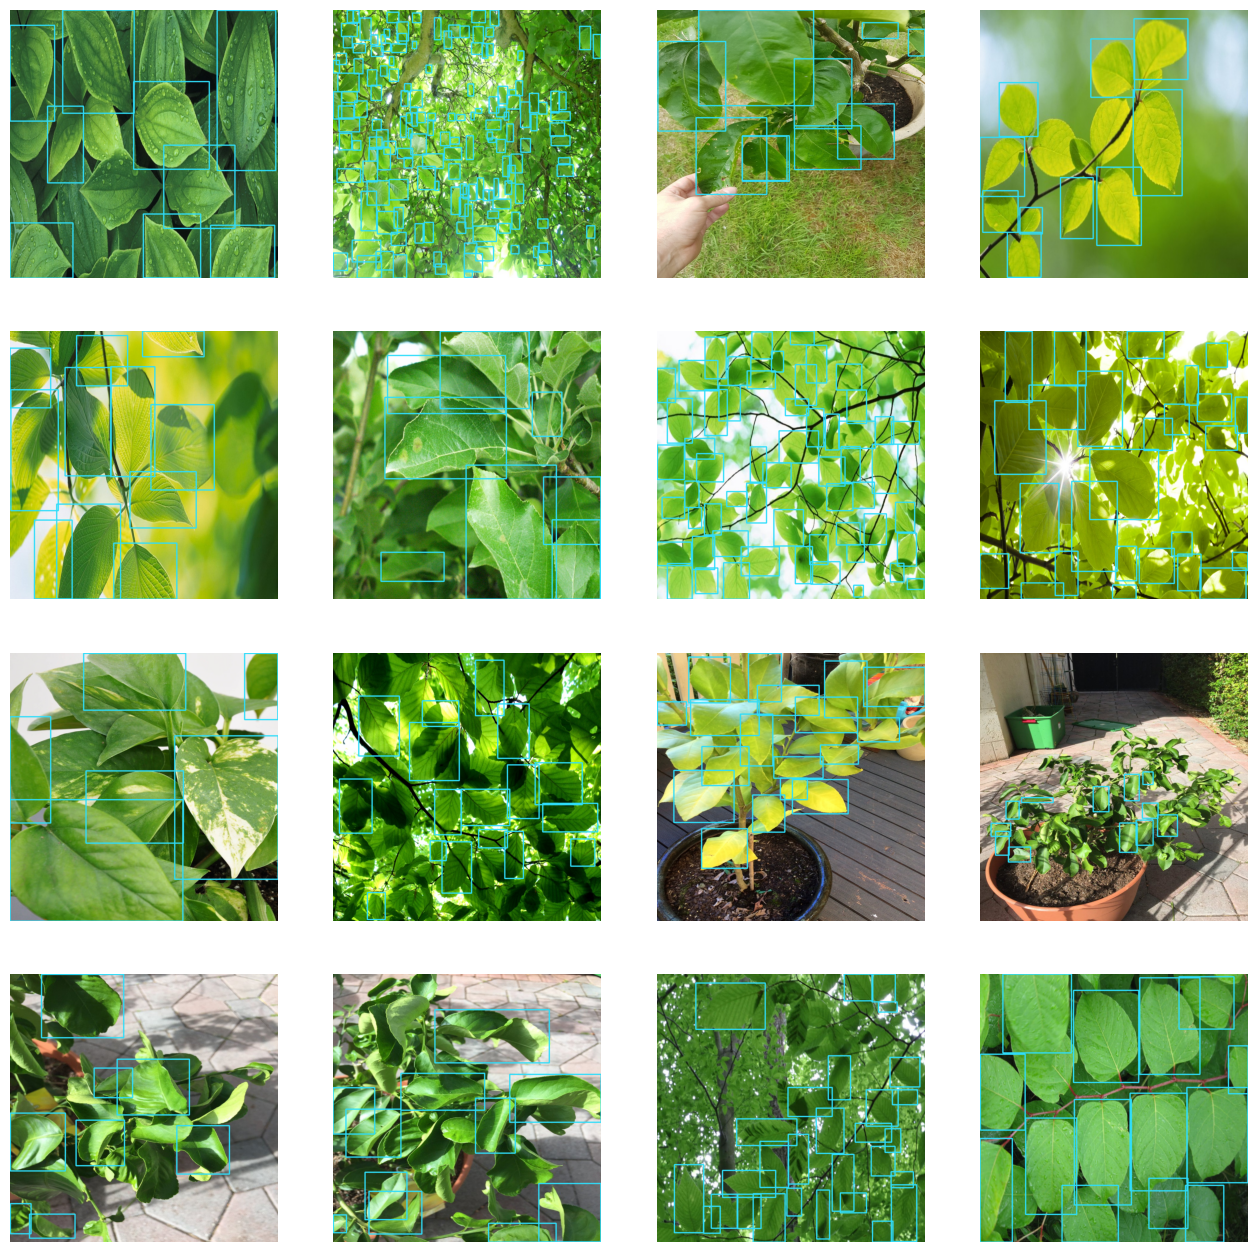

In [11]:
import math
import os
from PIL import Image
import matplotlib.pyplot as plt

#make sure that your data is correctly drawing bounding boxes on the leaves 

def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        print(image_file)
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        if '.jpg' in image_path:
            print(image.shape)
            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_path = os.path.join(labels_dir, label_file)
            if(os.path.exists(label_path)):
                print(label_path)
    
                with open(label_path, "r") as f:
                    labels = f.read().strip().split("\n")
                for label in labels:
                    if len(label.split()) != 5:
                        continue
                    class_id, x_center, y_center, width, height = map(float, label.split())
                    x_min = int((x_center - width / 2) * image.shape[1])
                    y_min = int((y_center - height / 2) * image.shape[0])
                    x_max = int((x_center + width / 2) * image.shape[1])
                    y_max = int((y_center + height / 2) * image.shape[0])
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
                axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axs[row, col].axis('off')
    plt.show()

print(os.getcwd())
train_images = img_files_train
train_labels = txt_files_train

plot_images_with_detections(train_images, train_labels)

In [12]:
from ultralytics import YOLO
import torch

model = YOLO("yolov8n.pt") 

#this has to be the absolute path for data.yaml to work 

model_output_path = '/tf/Samuel_Plant_Disease/Yolo_test_run2/Leaf_Detect_output'
print(os.path.exists(model_output_path))
data_yaml = os.path.join(model_output_path, 'data.yaml')

# move_to_dest_dir()

#by defualt, this will save the result of your run in a directory called runs 
model.train(data=data_yaml, epochs = 60,
            imgsz = 640,
            seed = random_seed,
            batch = 8,
            workers = 4)

# model.train(data='data.yaml', epochs = 60,
#             imgsz = 128,
#             seed = random_seed,
#             batch = 8,
#             workers = 4)

100%|██████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 10.5MB/s]


True
New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.51 🚀 Python-3.11.0rc1 torch-2.3.1+cu121 CPU (Intel Core(TM) i7-9700 3.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/tf/Samuel_Plant_Disease/Yolo_test_run2/Leaf_Detect_output/data.yaml, epochs=60, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes

train: Scanning /tf/Samuel_Plant_Disease/Yolo_test_run2/Leaf_Detect_output/train/labels... 904 images, 0 backgrounds, 0 

train: New cache created: /tf/Samuel_Plant_Disease/Yolo_test_run2/Leaf_Detect_output/train/labels.cache



/home/samuel/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
val: Scanning /tf/Samuel_Plant_Disease/Yolo_test_run2/Leaf_Detect_output/valid/labels... 113 images, 0 backgrounds, 0 co

val: New cache created: /tf/Samuel_Plant_Disease/Yolo_test_run2/Leaf_Detect_output/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60         0G      1.523       2.97      1.676         33        640:   2%|▏         | 2/113 [00:09<09:08,  4.9


KeyboardInterrupt: 

In [ ]:
csv_path = 'runs/detect/train59/results.csv'

def show_csv_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
    sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
    sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
    sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
    sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
    sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
    sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
    sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
    sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
    sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])
    axs[0,0].set(title='Train Box Loss')
    axs[0,1].set(title='Train Class Loss')
    axs[1,0].set(title='Train DFL Loss')
    axs[1,1].set(title='Metrics Precision (B)')
    axs[2,0].set(title='Metrics Recall (B)')
    axs[2,1].set(title='Metrics mAP50 (B)')
    axs[3,0].set(title='Metrics mAP50-95 (B)')
    axs[3,1].set(title='Validation Box Loss')
    axs[4,0].set(title='Validation Class Loss')
    axs[4,1].set(title='Validation DFL Loss')
    plt.suptitle('Training Metrics and Loss', fontsize=24)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()    

show_csv_results(csv_path)

In [ ]:
! nvidia-smi

In [11]:
model = YOLO('runs/detect/train59/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics YOLOv8.2.51 🚀 Python-3.11.0rc1 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7791MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/samuel/Samuel_Plant_Disease/datasets/Leaf_Detect_output/test/labels.cache... 113 images, 0 backgrou
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<0


                   all        113        626      0.679      0.681      0.731      0.508
Speed: 1.3ms preprocess, 6.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val15


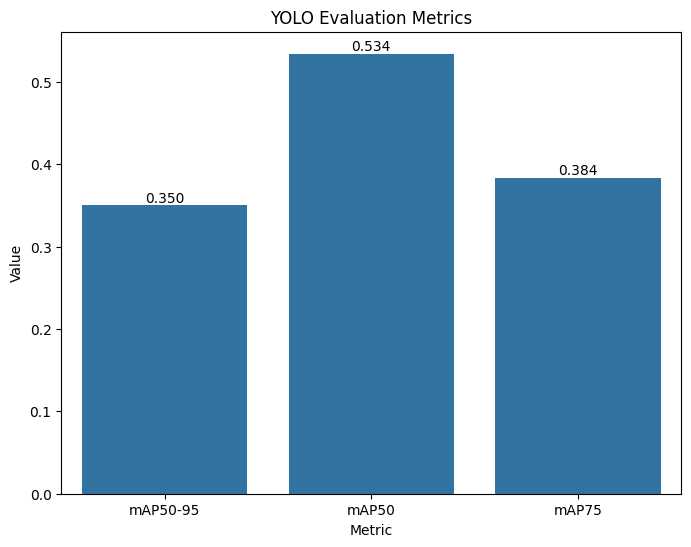

In [199]:

def show_metrics(metrics):
    # Create the barplot
    ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])
    # Set the title and axis labels
    ax.set_title('YOLO Evaluation Metrics')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    # Set the figure size
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    # Add the values on top of the bars
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    # Show the plot
    plt.show()    


show_metrics(metrics)


In [13]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def no_background_image(mask, original_image): #image should be of shape 160, 160, 3
    # print("APPLY THE MASK")
    original_image = np.array(original_image)    
    original_image = original_image
    # Boolean mask to identify non-zero values in the mask
    non_zero_mask = np.broadcast_to(mask == 1, original_image.shape)

    
    # Assign corresponding colors from original image to new image where mask is non-zero

    # original_image[non_zero_mask] = 0.0 #random.uniform(0.0, 200.0) #random number between black to gray  0.0 # original_image[non_zero_mask]
    # print("Original Image IS: ")
    # print(original_image)
    #return original_image
    inverted_mask = 1 - mask

    masked_image = tf.multiply(original_image, inverted_mask)
    return masked_image


# mask_background_model = tf.keras.models.load_model('seg94.keras')
def normalize_img(image):
    print(image.shape)
    image = cv2.resize(image, (128, 128))
    print(image.shape)
    return image




In [15]:
#convert the YOLO model to tflite 
! yolo export model= runs/detect/train59/weights/best.pt format=tflite


Ultralytics YOLOv8.2.51 🚀 Python-3.11.0rc1 torch-2.3.1+cu121 CPU (Intel Core(TM) i7-9700 3.00GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train59/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnxruntime'] not found, attempting AutoUpdate...
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.2 MB/s 